In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gp
from os.path import join, basename
from datetime import date, datetime

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from plot_tools import *
import seaborn as sns
from string import ascii_uppercase as letters

In [3]:
root = r'/scratch/compound_hotspots'
ddir = join(root, 'data', '4-postprocessed')
fdir = join(root, 'reports', 'figures')

In [4]:
rc = {'savefig.bbox': 'tight',  'savefig.format': 'png', 'savefig.dpi':300}
context = 'paper'
# sns.set(context=context, style='whitegrid', font_scale=0.75 if context == 'talk' else 1., rc=rc)
sns.set(context=context, style='whitegrid', font_scale=1.2 if context == 'paper' else 1., rc=rc)

cmap_div = sns.diverging_palette(220, 10, s=75, l=40, sep=1, as_cmap=True)

plot_kwargs=dict(edgecolor=(0.5, 0.5, 0.5, 0.8), linewidth=0.5, legend=False, zorder=2)
box_kwargs=dict(whis=[5,95], showfliers=False, boxprops=dict(linewidth=1.5), medianprops=dict(linewidth=1.5))

In [5]:
attrs_fn = join(ddir, 'rivmth_mean_attrs.csv')
attrs = pd.read_csv(attrs_fn, index_col='index').rename(columns={'rivmth_lat':'lat', 'rivmth_lon':'lon'})
attrs['Q_amax'] = np.log10(attrs['Q_amax'])
attrs['Qmsl_amax'] = np.log10(attrs['Qmsl_amax'])
attrs['uparea'] = np.log10(attrs['uparea'])
attrs['Hseasrange'] = attrs['Hseas_amax']-attrs['Hseas_amin']

In [7]:
q = 95
min_dist = 14
method='_empirical'
fn_diff_stats = join(ddir, f'rivmth_peaks_q{q}d{min_dist}_rp_diff.nc')
ds_diff_stats = xr.open_dataset(fn_diff_stats)
ds_diff_stats.sel(index=1802)['diff_surge_tide'].load() #.to_series().unstack().T

<xarray.DataArray 'diff_surge_tide' (stat: 2, rp: 7)>
array([[      nan, -0.009071, -0.011718, -0.01211 , -0.021501, -0.019691,
        -0.019002],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  1.      ,  0.      ,
         0.      ]])
Coordinates:
    gtsm_lat         float32 44.97396
    gtsm_lon         float32 12.50977
    gtsm_station_id  |S40 b'deltas_059'
    index            int64 1802
    percentile       int64 95
    rivmth_idx       int64 9001
    rivmth_lat       float64 44.97
    rivmth_lon       float64 12.53
  * rp               (rp) int64 1 2 5 10 20 30 35
  * stat             (stat) object 'mean' 'sign'

In [ ]:
from scipy.stats import gaussian_kde
qmin=0
vs = {
#     'tidal_range': dict(lim=[0, 9.9], label='mean tidal range [m]'), 
    'Hsurge_amax': dict(lim=[0, 1.05], label='mean an. max\nHsurge [m]', xticks=np.arange(0,1.01,.2), fmt='{:.1f}'),
    'Hseas_amax': dict(lim=[0, 0.25], label='mean an. max\nHseas [m]', xticks=np.arange(0,0.26,0.05), fmt='{:.1f}'),

#     'Hseasrange': dict(lim=[0, 0.55], label='mean an. max range\nseasonal MSL variations [m]', xticks=np.arange(0,.55,.1), fmt='{:.1f}'),
    'Q_amax': dict(lim=[np.log10(np.max([qmin,10])), 5], label='mean an. max\ndischarge [m$^3$/s]', xticks=range(1,5), fmt='10$^{:d}$'),
    'uparea': dict(lim=[3, 6.5], label='catchment area [km$^2$]', xticks=range(3,7), fmt='10$^{:d}$'),
}
hist_kws={"histtype": "step", "linewidth": 1.5, "alpha": 1, "color": "m"}
cmax= {0: 300, 10: 200}

for var in ['diff_surge_tide']: #list(ds_ratio_stats.data_vars.keys())[:1]:
    for rp in [2]: #[1, 2, 10, 20]:
        if var.startswith('ratio'):
            label=f'ratio change return level\nrp {rp} year [-]'
        else:
            label=f'difference return level\nrp {rp} year [m]'
        attrs2 = pd.concat([
            attrs.copy(),
            ds_diff_stats[var].sel(rp=rp).to_series().unstack(-1).T
        ], axis=1)
        attrs_sign = attrs2[attrs2['sign']==1]
        vmin, vmax = np.percentile(attrs_sign['mean'].values, [2, 98])
        vmin, vmax = np.maximum(vmin, -0.1), np.maximum(vmax, 0.2)
        palette= "ch:start=.5, rot=-.75"
        cmap_dens = ListedColormap(sns.color_palette(palette, 100).as_hex())
        fig, axs = plt.subplots(1, len(vs), figsize=(len(vs)*4+1, 4), sharey=True, gridspec_kw=dict(hspace=0.1))

        # density
        # norm=plt.Normalize(vmin=0, vmax=1)
        # sm = plt.cm.ScalarMappable(cmap=cmap_dens, norm=norm)

        y = attrs_sign['mean'].values
        for i, (ax, v) in enumerate(zip(axs, vs)):
            # Calculate the point density
            x = attrs_sign[v].values.copy()
            xy = np.vstack([x,y.copy()])
            z = gaussian_kde(xy)(xy)
            idx = z.argsort()
            x, y, z = x[idx], y[idx], z[idx]
            sns.scatterplot(x=x, y=y, hue=z, ax=ax, linewidth=0, palette=palette, s=30, legend=False)
            ax.set_xlim(vs[v]['lim'])
            if 'xticks' in vs[v]:
                ax.set_xticks(vs[v]['xticks'])
                ax.set_xticklabels([vs[v]['fmt'].format(x) for x in vs[v]['xticks']])
            ax.set_xlabel(vs[v]['label'])
            ax.text(0.05, 0.95, letters[i], weight='bold',
                   horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, )
            if i == 0:
                ax.set_ylabel(label)
                ax.set_ylim([vmin, vmax])
            if i == (len(axs)-1):
                norm=plt.Normalize(vmin=0, vmax=1)
                sm = plt.cm.ScalarMappable(cmap=cmap_dens, norm=norm)
                the_divider = make_axes_locatable(ax)
                caxis = the_divider.append_axes("right", size="5%", pad=0.1)
                sm._A = []
                cbar = plt.colorbar(sm, cax=caxis)
                cbar.set_label('normalized density [-]')
                ticks = [0, 0.5, 1]
                cbar.set_ticks(ticks)
                cbar.set_ticklabels(['{:.1f}'.format(t) for t in ticks])

        fn = join(fdir, f'scatter_{var}_q{q}d{min_dist}_rp{rp:02d}{method}.png')
        plt.savefig(fn)
#         plt.close('all')
        print(basename(fn))
#         break
#     break

In [ ]:
fig, ax = plt.subplots(1, 1,)
attrs_sign = attrs_sign.sort_values(by='mean', ascending=True)
x, y, z = attrs_sign['uparea'], attrs_sign['Hsurge_amax'], attrs_sign['mean']
ax.scatter(x=x, y=y, c=z, linewidth=0, cmap=cmap_turbo, s=30, vmax=0.5, vmin=-0.1)
ax.set_xlabel('uparea')
ax.set_ylabel('surge')

## bivariate plots

In [8]:
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
from lmoments3 import distr
import sys
import os
sys.path.append(os.path.abspath('../3-postprocess/'))
import peaks as xpeaks
import xstats as xs 

In [9]:
model='cnrs'
fn_rivmth_ts = join(ddir, 'rivmth_reanalysis.zarr')
ds_rivmth = xr.open_zarr(fn_rivmth_ts)
ds_rivmth = ds_rivmth[['WSE', 'Htot_day_max', 'Qmsl', 'Hskewsurge_day', 'Htide_day_max']].sel(scen='surge', ensemble=model).reset_coords(drop=True)

In [17]:
loc = 1617 # #499 #1728 #1648 #1230 #1648 #1230
nyears=35
min_dist=14
q=95

ds_ts = ds_rivmth.sel(index=loc).reset_coords(drop=True)
df_ts = ds_ts.to_dataframe()
df_peaks = xr.merge([
    xpeaks.get_peaks(ds_ts.drop('Qmsl'), min_dist=min_dist, dim='time').reset_coords(drop=True),
    xpeaks.get_peaks(ds_ts[['Qmsl']], min_dist=min_dist, dim='time').reset_coords(drop=True)
]).to_dataframe()
for var in df_ts.columns:
    df_ts[f'{var}_rp'] = xs._interp_ev(df_peaks[var].values, df_ts[var].values, nyears) 

events = df_peaks.index[df_peaks['WSE'] > df_ts['WSE'].quantile(q/100.)]

df_ts1 = df_ts.rolling(3, min_periods=1,center=True).max()
dfs = [
    df_ts.loc[events,:],
    df_ts1.loc[events,:]
]

/opt/miniconda3/envs/compound_analysis/lib/python3.7/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/miniconda3/envs/compound_analysis/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/opt/miniconda3/envs/compound_analysis/lib/python3.7/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/miniconda3/envs/compound_analysis/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


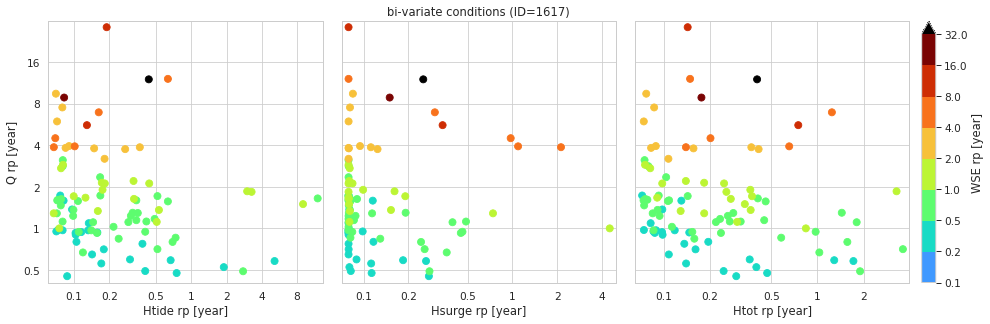

In [18]:
rps = [0.1, 0.2, 0.5, 1, 2, 4, 8, 16, 32]
cmap = ListedColormap(google_turbo_data[50:])
cmap.set_over('black')
norm = BoundaryNorm(rps, cmap.N)
kwargs = dict(cmap=cmap, norm=norm, colorbar=False, y='Qmsl_rp',  c='WSE_rp')
cols = dict(
    x0='Htide_day_max_rp',
    x1='Hskewsurge_day_rp', 
    x2='Htot_day_max_rp', 
)
labs = dict(
    x0 = 'Htide rp [year]',
    x1 = 'Hsurge rp [year]',
    x2 = 'Htot rp [year]',
    y = 'Q rp [year]',
    c = 'WSE rp [year]',
)
window_size=1

df_ = dfs[window_size].sort_values('WSE', ascending=True).copy()

x0min,x1min,x2min, ymin = df_[[cols['x0'],cols['x1'],cols['x2'],kwargs['y']]].min().values
x0max,x1max,x2max, ymax = df_[[cols['x0'],cols['x1'],cols['x2'],kwargs['y']]].max().values

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4.5), sharey=True)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')

df_.plot.scatter(ax=ax0, s=50, x=cols['x0'], **kwargs)
df_.plot.scatter(ax=ax1, s=50, x=cols['x1'], **kwargs)
df_.plot.scatter(ax=ax2, s=50, x=cols['x2'], **kwargs)
fig.tight_layout()
pos = ax2.get_position()
cax = fig.add_axes([1., pos.y0, 0.015, pos.height])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='max')

ax0.set_ylabel(labs['y'])
ax0.set_xlabel(labs['x0'])
ax1.set_xlabel(labs['x1'])
ax2.set_xlabel(labs['x2'])
cax.set_ylabel(labs['c'])

rps2 = [0.02, 0.05]+rps
ax1.set_yticks(rps2)
ax1.set_yticklabels(rps2)
ax0.set_xticks(rps2)
ax0.set_xticklabels(rps2)
ax1.set_xticks(rps2)
ax1.set_xticklabels(rps2)
ax2.set_xticks(rps2)
ax2.set_xticklabels(rps2)

ax1.set_ylim([ymin*0.9, ymax*1.1])
ax0.set_xlim([x0min*0.9, x0max*1.1])
ax1.set_xlim([x1min*0.9, x1max*1.1])
ax2.set_xlim([x2min*0.9, x2max*1.1])
##
ax1.set_title(f'bi-variate conditions (ID={loc})')
fn = join(fdir, f'bivariate_loc{loc:04d}_{model}_q{q}d{min_dist}_wdw{window_size}_rp.png')
plt.savefig(fn)

## EV

In [19]:
da_wse = xr.open_zarr(fn_rivmth_ts)['WSE'].sel(ensemble=model)
da_wse_ts = da_wse.sel(index=loc).reset_coords(drop=True).load()
q95 = da_wse_ts.quantile(q/100., dim='time')
da_wse_peaks = xpeaks.peaks_over_threshold(da_wse_ts, threshold=q95, min_dist=min_dist).load()

/opt/miniconda3/envs/compound_analysis/lib/python3.7/site-packages/dask/compatibility.py:107: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/miniconda3/envs/compound_analysis/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/opt/miniconda3/envs/compound_analysis/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


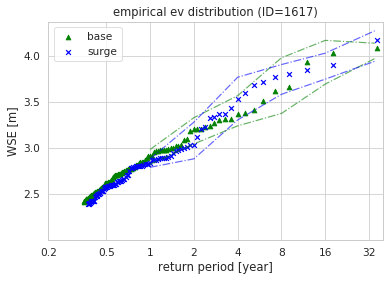

In [20]:
scen_cmap = {'surge': 'blue', 'seas': 'cyan', 'tide': 'green'}
scen_mmap  = {'surge': 'x', 'seas': 'o', 'tide': '^'}
scen_labs  = {'surge': 'surge', 'tide': 'base'}
rps_out = np.array([1, 2, 4, 8, 16, 35])
kwargs = dict(nyears=35, rp=rps_out)

fig, ax = plt.subplots(1,1)

for scen in ['tide', 'surge']:
    peaks = da_wse_peaks.sel(scen=scen).values
    peaks = peaks[np.isfinite(peaks)]
    rps_in, peaks = xs.weibull(peaks, nyears=35)
    ax.scatter(rps_in, peaks, c=scen_cmap[scen], marker=scen_mmap[scen], label=scen_labs[scen])

#     swe_rp, par = xs.lm_fit(peaks, fdist=distr.gpa, **kwargs)
#     ax.plot(rps_out, swe_rp, color=scen_cmap[scen])
    
#     swe_rp2 = xs._interp_rps(peaks, rps_in, rps_out)
#     ax.plot(rps_out, swe_rp2, color=scen_cmap[scen], linestyle='--')

    ci = xs._interp_rps_ci(peaks, n_samples=10000, alphas=np.array([0.05, 0.95]), **kwargs)
    ax.plot(rps_out, ci[0,:], color=scen_cmap[scen], linestyle='-.', alpha=0.6)
    ax.plot(rps_out, ci[1,:], color=scen_cmap[scen], linestyle='-.', alpha=0.6)
    
    if scen == 'tide':
        ymin = xs._interp_rps(peaks, np.array([0.2]), nyears)[0]
    
#     ci = xs.lm_fit_ci(peaks, n_samples=1000, fdist=distr.gpa, **kwargs)
#     ax.plot(rps_out, ci[0,:], color=scen_cmap[scen], linestyle='--', alpha=0.6)
#     ax.plot(rps_out, ci[1,:], color=scen_cmap[scen], linestyle='--', alpha=0.6)
ax.set_xscale('log')
ax.set_xticks(rps)
ax.set_xticklabels(rps)
ax.set_xlim([0.2,40])
ylim = ax.get_ylim()
ax.set_ylim([ymin*0.98, ylim[-1]])
ax.set_ylabel('WSE [m]')
ax.set_xlabel('return period [year]')
ax.set_title(f'empirical ev distribution (ID={loc})')
ax.legend()
fn = join(fdir, f'ev_loc{loc:04d}_{model}_q{q}d{min_dist}.png')
plt.savefig(fn)